In [1]:
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [14]:
df = pd.read_parquet('./data/fhv_tripdata_2021-01.parquet')

# Stats

## Question 1: Number of records in Jan 2021 FHV data

In [15]:
df.shape

(1154112, 7)

## Question 2: Average duration in Jan 2021 FHV

In [16]:
df['duration'] = df.dropOff_datetime - df.pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

In [17]:
df.duration.mean()

19.1672240937939

## Question 3: Fraction of missing values

In [27]:
sum(df["PUlocationID"].isna() & df["DOlocationID"].isna()) / df.shape[0]

0.13064503271779515

In [28]:
(sum(df["PUlocationID"].isna()) + sum(df["DOlocationID"].isna())) / (df.shape[0] * 2)

0.48543252301336437

In [29]:
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})
missing_value_df

,column_name,percent_missing
dispatching_base_num,dispatching_base_num,0.000000
pickup_datetime,pickup_datetime,0.000000
dropOff_datetime,dropOff_datetime,0.000000
PUlocationID,PUlocationID,83.030676
DOlocationID,DOlocationID,14.055828
SR_Flag,SR_Flag,100.000000
Affiliated_base_number,Affiliated_base_number,0.076682
duration,duration,0.000000


In [33]:
sum(df.isnull().sum()) / (len(df) * 4)

0.49290796733765874

# Filtering

In [34]:
df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PUlocationID', 'DOlocationID']
# numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

/var/folders/tn/dr7n33yd0r5bc46xcd0jpd3r0000gn/T/ipykernel_8113/872856045.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[categorical] = df[categorical].astype(str)


# Model

In [35]:
train_dicts = df[categorical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

10.528519107203781

## Question 4: Dimensionality after OHE

In [36]:
X_train.shape

(1109826, 525)

## Question 5: RMSE on train

- RMSE: 10.52

/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


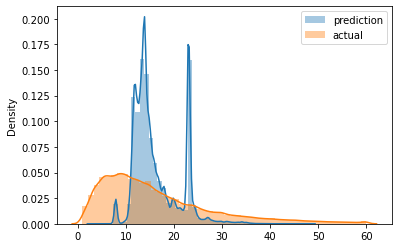

In [38]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [37]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.dropOff_datetime - df.pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PUlocationID', 'DOlocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [39]:
df_train = read_dataframe("./data/fhv_tripdata_2021-01.parquet")
df_val = read_dataframe('./data/fhv_tripdata_2021-02.parquet')

In [40]:
len(df_train), len(df_val)

(1109826, 990113)

In [41]:
df_train['PU_DO'] = df_train['PUlocationID'] + '_' + df_train['DOlocationID']
df_val['PU_DO'] = df_val['PUlocationID'] + '_' + df_val['DOlocationID']

In [46]:
categorical = ['PU_DO']

dv = DictVectorizer()

train_dicts = df_train[categorical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [47]:
X_train.shape

(1109826, 19683)

In [49]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [50]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

10.596293717089068

In [51]:
lr = Lasso(0.01)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

11.34764990224504

In [58]:
def vectorize(df, train=False):
    categorical = ['PUlocationID', 'DOlocationID']
    dicts = df[categorical].to_dict(orient='records')

    if train:
        dv = DictVectorizer()
        X = dv.fit_transform(dicts)
    
        with open('models/dv.bin', 'wb') as f_out:
            pickle.dump(dv, f_out)
    else:
        with open('models/dv.bin', 'rb') as f_in:
            dv = pickle.load(f_in)
        X = dv.transform(dicts)
    
    target = 'duration'
    y = df[target].values
    
    return X, y

In [59]:
X_train, y_train = vectorize(df_train, train=True)
X_val, y_val = vectorize(df_val)

In [64]:
def model(X_train, y_train):
    lr = LinearRegression()
    lr.fit(X_train, y_train)

    with open('models/lin_reg.bin', 'wb') as f_out:
        pickle.dump(lr, f_out)
        
    return lr

In [65]:
lr = model(X_train, y_train)

In [67]:
def validation(model, X, y):
    y_pred = model.predict(X)

    print("RMSE:", mean_squared_error(y, y_pred, squared=False))

In [69]:
print("Train")
validation(lr, X_train, y_train)
print("Val")
validation(lr, X_val, y_val)

Train
RMSE: 10.528519107203781
Val
RMSE: 11.014283141597323
